In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from toolz import concat
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
format_plots()

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#008C8D','white','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['white','gray']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c']
cml = sns.blend_palette(colors, n_colors=256, as_cmap=True)

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [5]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
m_df= male_df.groupby(['age','uuid']).mean()

## arrange data
female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]
f_df= female_df.groupby(['age','uuid']).mean()

# for female:
f_df= female_df.groupby(['age','uuid']).mean()
# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4','e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33']
f_df.reset_index(inplace=True)
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
f_df.set_index(['age', 'uuid'], inplace=True)

In [6]:
# use only common ages
f_ages = f_df.index.get_level_values('age').unique().to_numpy()
m_ages = m_df.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))
if 90 in cages:
    cages.remove(90)
    
m_data = m_df.loc[m_df.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_df.loc[f_df.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

# use the same number of mice per age - only age 80
# Get indices of rows where age is 80
indices = m_data[m_data.index.get_level_values('age') == 80].index
# Choose a random index
np.random.seed(0)
random_index = np.random.choice(indices)
# Remove the row with the selected index
m_data = m_data.drop(random_index)

In [7]:
#average and normalize male
avg_m_df = m_data.groupby(['age']).mean()
# normalize the data
m_norm = mm_norm_col(m_data)
avg_m_norm = mm_norm_col(avg_m_df)

#average and normalize female
avg_f_df = f_data.groupby(['age']).mean()
# normalize the data
f_norm = mm_norm_col(f_data)
avg_f_norm = mm_norm_col(avg_f_df)

In [8]:
# Calculate p-values using scipy's pearsonr function
from scipy.stats import spearmanr
correlation_matrix = avg_m_norm.corrwith(avg_f_norm, axis=0, method='spearman')

p_values = avg_m_norm.apply(lambda col: spearmanr(col, avg_f_norm[col.name])[1]) #change by number of syllables used

#colors = ['purple' if value > 0 else 'orange' for value in new_diff]

# Combine results into a DataFrame
result_df = pd.DataFrame({'Correlation': correlation_matrix, 'P-Value': p_values})

In [9]:
sorted_result_df = result_df.sort_values(by='Correlation', ascending=False)

In [10]:
sorted_result_df['P-Value']*len(keep_syllables)

syllables
0      0.000746
12     0.007286
13     0.012792
9      0.013991
50     0.070178
60     0.123580
54     0.131653
83     0.158560
5      0.184345
49     0.184345
33     0.333746
98     0.691339
4      0.741450
74     0.812786
25     0.812786
97     0.850471
11     1.083627
84     1.256800
44     1.393432
70     1.510985
93     1.541562
42     1.604177
6      1.604177
52     1.636227
77     1.874912
79     2.140000
18     2.220849
76     3.007407
10     3.330630
32     3.740308
71     3.864051
55     4.186859
62     4.818136
73     5.276426
85     5.850645
41     6.842862
68     9.534605
63     9.900477
27    12.440999
66    18.715325
39    19.279018
61    19.660314
14    20.045997
7     22.039608
53    25.229196
69    27.253398
17    27.714063
90    32.276626
95    39.546281
2     47.599122
67    48.168688
30    51.036009
23    57.417664
36    49.885504
16    49.598581
24    48.168688
64    38.472894
59    17.084016
Name: P-Value, dtype: float64

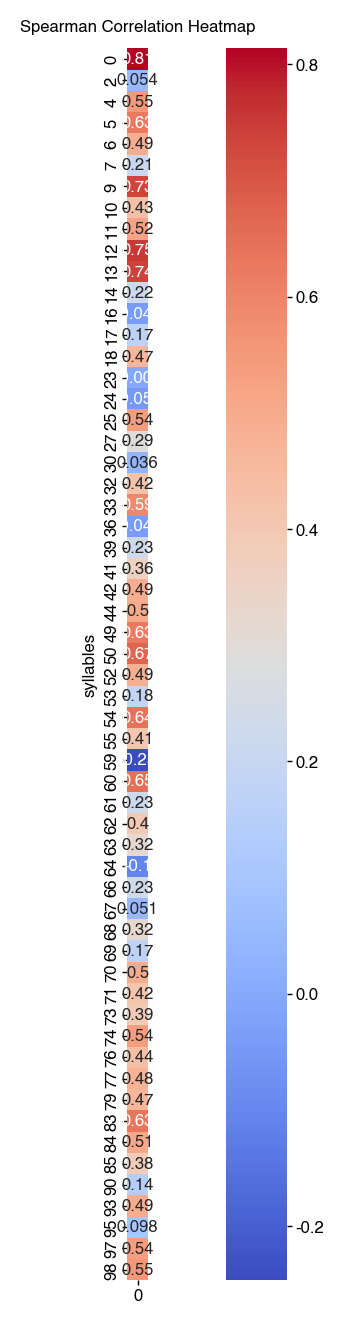

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap="coolwarm", cbar=True, square=True)
plt.title("Spearman Correlation Heatmap")
plt.show()

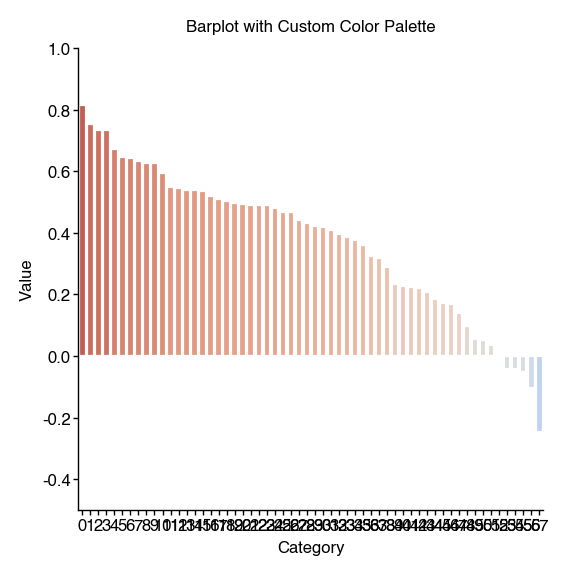

In [13]:
# Create a DataFrame from the correlation values list
from matplotlib.colors import TwoSlopeNorm
# Plotting
fig, ax = plt.subplots()
fig.set_size_inches(3,3)

# Create a DataFrame from the correlation values list
sorted_result_df = result_df.sort_values(by='Correlation', ascending=False)
df = sorted_result_df.copy()
df['category'] =  -df['Correlation'].rank()
df['value'] = df['Correlation']

# Assume you have your data in a DataFrame called 'df'
# with columns 'category' and 'value'

# Get the minimum and maximum values for normalization
#min_val = df['value'].min()
#max_val = df['value'].max()

min_val = -1
max_val = 1

# Create a TwoSlopeNorm object with the desired center value (0 in this case)
norm = TwoSlopeNorm(vmin=min_val, vcenter=0, vmax=max_val)

# Create a colormap object based on 'RdBu_r'
cmap = plt.cm.coolwarm

# Map the normalized values to colors using the colormap
colors = cmap(norm(df['value']))

# Create a custom color palette using the mapped colors
palette = sns.color_palette(colors)

# Create the barplot using Seaborn with the custom color palette
ax = sns.barplot(x=list(range(len(sorted_result_df))), y='value', data=df, palette=palette)

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Barplot with Custom Color Palette')
plt.ylim([-0.5,1])
sns.despine()
# Show the plot
plt.show()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'fvm_syll_crosscorr.pdf')